# ThAIMed 2024 Session 2
> Liam Barrett [(l.barrett.16@ucl.ac.uk)](l.barrett.16@ucl.ac.uk)

In this notebook, we wil demo training and evaluating various machine learning models using real clinical data. This notebook is adjunct to the lecture slides for ThAIMed 2024.

### IMPORTANT: RERUN THESE CELLS AFTER REFRESHING OR OPENING THE NOTEBOOK:
1. Import Libraries
2. Load and pre-process data

From there, you can run any cell you want 😀

### Troubleshooting

If you are having trouble with running this notebook (e.g. running a cell results in an error, or unexpected result) you may have lost connection to the compute backend. Please refresh the browser (hit continue if prompted) and then run all cells from the beginning. The 'Import libraries' and 'Load data' cells are most important to rerun.

If you are still having issues please message one of the TAs directly on Zoom and they'll be able to provide further support.

In [ ]:
# @title ## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from ipywidgets import interact, interactive, fixed, widgets
from IPython.display import display, HTML, clear_output
import ast

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_theme(context='notebook')

In [ ]:
# @title ## Load and pre-process data
# @markdown Here, we are loading in the NHANES health data from session 1. This includes, Demographics, Examination, Laboratory and Questionnaire data.
# @markdown
# @markdown You can see some example patient data below in the table.
# @markdown
# @markdown **Remember, we are looking to predict Diabetes and Glycohaemoglobin levels**
# @markdown
# @markdown The outputted data should be familiar from session 1.
# Load data
demographics_columns = [
    "RIAGENDR", "RIDAGEYR", "RIDRETH1", "DMDEDUC3", "DMDEDUC2", "INDHHIN2", "INDFMIN2"
]
examination_columns = [
    "BPXPLS", "BPXSY1", "BPXDI1", "BPXSY2", "BPXDI2", "BMXWT", "BMXHT", "BMXBMI", "BMXWAIST", "BMXHIP",
]
lab_columns = [
     "LBDHDD", "LBXTC", "LBXGLU", "LBXGH", "LBXTR", "LBDLDL", "LBDLDLM", "LBDLDLN",
]
questionnaire_columns = [
    "DIQ010"
]

demographics_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Data_scraper/NHANES_2017-2018/demographics.csv').set_index('SEQN')
dietary_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Data_scraper/NHANES_2017-2018/dietary.csv').set_index('SEQN')
examination_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Data_scraper/NHANES_2017-2018/examination.csv').set_index('SEQN')
labs_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Data_scraper/NHANES_2017-2018/laboratory.csv').set_index('SEQN')
questionnaire_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Data_scraper/NHANES_2017-2018/questionnaire.csv').set_index('SEQN')

encodings_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Dictionary_scraper/NHANES_2017-2018/encodings.csv')
description_df = pd.read_csv('https://raw.githubusercontent.com/RileyZurrin/NHANES_Extractor/main/Dictionary_scraper/NHANES_2017-2018/descriptions.csv')
master_df = demographics_df[demographics_columns]
master_df = master_df.join(other=[examination_df[examination_columns], labs_df[lab_columns], questionnaire_df[questionnaire_columns]], how="outer")

final_columns = list(master_df.columns)
master_encodings = encodings_df[encodings_df["Variable"].isin(final_columns)]
master_descriptions = description_df[description_df["Variable"].isin(final_columns)]
master_meta_df = master_descriptions.merge(right=master_encodings, on="Variable", how="outer").set_index('Variable')

master_meta_df['Encoding'] = master_meta_df['Encoding'].apply(ast.literal_eval)

categorical_features = [feature for feature in final_columns if len(master_meta_df['Encoding'][feature]) > 1]
continuous_features = [feature for feature in final_columns if feature not in categorical_features]

# Clean outcome feature
clean_df = master_df.copy()
clean_df = clean_df[~clean_df['DIQ010'].isin([7,9])]
clean_df = clean_df[~clean_df['DIQ010'].isna()]

# Drop any field that's missing more than 70% of the values
num_rows = clean_df.shape[0]
columns_to_drop = clean_df.columns[((clean_df.isna().sum() / num_rows) > 0.7)].to_list()
clean_df.drop(columns_to_drop, axis=1, inplace=True)

# Drop any row missing more than 50% of the entries
num_columns = len(clean_df.columns)

rows_to_drop = clean_df.index[((clean_df.isna().sum(axis=1) / num_columns) > 0.5)]
clean_df.drop(rows_to_drop, axis=0, inplace=True)

new_columns = clean_df.columns.to_list()
categorical_features = [feature for feature in categorical_features if feature in new_columns]
continuous_features = [feature for feature in continuous_features if feature in new_columns]

# Clean up annual household income
variable_to_update = 'INDHHIN2'
new_name = variable_to_update + '_adjusted'
new_label = 'Adjusted ' + master_meta_df['Label'][variable_to_update]
new_bins = {1: 0, 2: 0, 3: 0, 4: 0, 13: 0, 12: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 14: 2, 15: 3}
new_encoding = {0: '\$ 0 to \$19,999', 1: '\$20,000 to \$54,999', 2: '\$55,000 to \$99,999', 3: '\$100,000 and Over'}

master_meta_df.loc[new_name] = master_meta_df.loc[variable_to_update]

master_meta_df.loc[new_name, 'Label'] = new_label
master_meta_df.at[new_name, 'Encoding'] = new_encoding

clean_df[new_name] = clean_df[variable_to_update].map(new_bins)

clean_df[new_name].value_counts(dropna=False)

if new_name not in categorical_features:
  categorical_features.append(new_name)

# Drop any entries missing a value for Plasma Fasting Glucose
clean_df = clean_df[~clean_df['LBXGLU'].isna()]

# k-Nearest Neighbours imputation

from sklearn.impute import KNNImputer

missing_value_cat = -99
missing_value_cont = -98

temp_missing_df = clean_df.copy(deep=True)
temp_missing_df[categorical_features] = temp_missing_df[categorical_features].fillna(value=missing_value_cat)
temp_missing_df[continuous_features] = temp_missing_df[continuous_features].fillna(value=missing_value_cont)

knn_imputer_cat = KNNImputer(missing_values=-99, n_neighbors=1)
temp_imputed_df_cat = pd.DataFrame(knn_imputer_cat.fit_transform(temp_missing_df), index=clean_df.index, columns=clean_df.columns)
knn_imputer_cont = KNNImputer(missing_values=-98, n_neighbors=5)
temp_imputed_df_cont = pd.DataFrame(knn_imputer_cont.fit_transform(temp_missing_df), index=clean_df.index, columns=clean_df.columns)
knn_imputed_df = temp_imputed_df_cat
knn_imputed_df[continuous_features] = temp_imputed_df_cont[continuous_features]

# Standardise and normalise the continuous features

from sklearn.preprocessing import StandardScaler, MinMaxScaler

joint_df = knn_imputed_df.copy(deep=True)
standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(joint_df[continuous_features])
columns_standard = [column + '_standard' for column in master_df[continuous_features].columns]

joint_df.loc[:, columns_standard] = X_standard

# Run PCA
from sklearn.decomposition import PCA

X_continuous = joint_df[columns_standard]

n_components = 10
pca = PCA(n_components=n_components)
pca_column_labels = [f"PC{i}" for i in range(1, n_components + 1)]

X_continuous_transformed = pca.fit_transform(X_continuous)
joint_df.loc[:, pca_column_labels] = X_continuous_transformed

for name in pca_column_labels:
  master_meta_df.loc[name, 'Label'] = name

joint_df = joint_df[joint_df['DIQ010'] != 3]
df_for_pred_widget = joint_df.copy()

code_labels = master_meta_df.iloc[:, 1].to_frame()
code_labels['variable'] = code_labels.index
code_labels.reset_index(inplace=True, drop=True)
code_to_label = dict(zip(code_labels['variable'], code_labels['Label']))

# Define the columns to keep
columns_to_keep = ['RIAGENDR', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI', 'LBDLDL', 'LBXGH', 'DIQ010']

# Create a copy of the joint_df with only the specified columns
reduced_df = joint_df[columns_to_keep].copy()

# Replace the machine-readable column names with human-readable names
reduced_df.rename(columns=code_to_label, inplace=True)
# Rename the 'Doctor told you have diabetes' column to 'Diabetes'
reduced_df.rename(columns={'Doctor told you have diabetes': 'Diabetes'}, inplace=True)

# Define the mappings for RIAGENDR and DIQ010
gender_mapping = {1: 'Male', 2: 'Female'}
diabetes_mapping = {1: 'Diabetes=Yes', 2: 'Diabetes=No'}

# Create a copy of the reduced_df to apply the mappings
string_labels_df = reduced_df.copy()

# Replace the numerical values with string labels
string_labels_df['Gender'] = string_labels_df['Gender'].map(gender_mapping)
string_labels_df['Diabetes'] = string_labels_df['Diabetes'].map(diabetes_mapping)

# Display the dataframe with string labels
string_labels_df.head()

,Gender,Age in years at screening,Weight (kg),Standing Height (cm),Body Mass Index (kg/m**2),"LDL-Cholesterol, Friedewald (mg/dL)",Glycohemoglobin (%),Diabetes
SEQN,,,,,,,,
93711.0,Male,56.0,62.1,170.6,21.3,156.0,5.7,Diabetes=No
93717.0,Male,22.0,74.4,174.1,24.5,140.0,5.1,Diabetes=No
93718.0,Male,45.0,54.4,157.3,22.0,80.0,5.7,Diabetes=No
93719.0,Female,13.0,67.0,160.5,26.0,35.0,5.0,Diabetes=No
93721.0,Female,60.0,85.1,154.0,35.9,61.0,5.2,Diabetes=No


## From Theory to Practice
Now, we are going to take what we learnt in the lecture and visualise the process of model training. We will consider different aspects of the model training process and look to see how this changes our resultant ML model.

In [ ]:
#@title ## How does dataset size change the learnt model?
#@markdown Can you think why we would visualise this?
#@markdown
#@markdown **Why are we interested in how a model changes as it gets more data?**
#@markdown
#@markdown Hint: Think of rate of change.
#@markdown
#@markdown This can sometimes take a moment when re-generating the plot after changing dataset size. Just wait a moment and it should load :)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from ipywidgets import interact, widgets

# Select relevant columns
selected_features = ['LDL-Cholesterol, Friedewald (mg/dL)', 'Glycohemoglobin (%)']

# Prepare data
X = reduced_df[selected_features].values
y = reduced_df['Diabetes'].values

# Define diabetes mapping for meaningful legend values
diabetes_mapping = {2: 'Non-Diabetic', 1: 'Diabetic'}

# Pre-train models for different dataset sizes
model_storage = {}
iteration_steps = [10, 50, 100, 200, 500, 1000, reduced_df.shape[0]]  # Fewer, more significant sizes

for iteration in iteration_steps:
    if iteration > X.shape[0]:
        break
    X_iter = X[:iteration]
    y_iter = y[:iteration]

    model = LogisticRegression()
    model.fit(X_iter, y_iter)

    model_storage[iteration] = model

# Function to plot decision boundary
def plot_decision_boundary(X, y, model, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    scatter = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('LDL-Cholesterol, Friedewald (mg/dL)')
    ax.set_ylabel('Glycohemoglobin (%)')

    # Update the legend to show meaningful labels
    handles, labels = scatter.get_legend_handles_labels()
    labels = [diabetes_mapping[int(float(label))] for label in labels]
    ax.legend(handles, labels, title="Diabetes Status")

# Function to handle widget interaction
def successive_iterations(iteration):
    model = model_storage[iteration]
    X_iter = X[:iteration]
    y_iter = y[:iteration]

    fig, ax = plt.subplots(figsize=(10, 6))
    plot_decision_boundary(X_iter, y_iter, model, ax, f'Logistic Regression Decision Boundary\nDataset size: {iteration}')
    plt.show()

# Create widget
interact(
    successive_iterations,
    iteration=widgets.SelectionSlider(
        options=iteration_steps,
        value=50,
        description='Dataset size:',
        continuous_update=False
    )
);

interactive(children=(SelectionSlider(continuous_update=False, description='Dataset size:', index=1, options=(…

In [ ]:
#@title ## How does different methds of splitting the data change the shape?
#@markdown Note, we are using different colours because this is separating training and test sets. Not, different classes as before.
#@markdown
#@markdown I have also included a erroneous split type. **What is wrong with this way of splitting the data?**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from ipywidgets import interact, widgets
import os
import pickle

# Prepare data
selected_features = ['LDL-Cholesterol, Friedewald (mg/dL)', 'Glycohemoglobin (%)']
X = reduced_df[selected_features].values
y = reduced_df['Diabetes'].values

def erroneous_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    positive_indices = np.where(y == 1)[0]
    negative_indices = np.where(y == 0)[0]

    # Ensure more cases of diabetes in test set
    test_positive_size = int(len(positive_indices) * test_size * 1.5)
    test_negative_size = int(len(negative_indices) * test_size * 0.5)

    test_positive_indices = np.random.choice(positive_indices, test_positive_size, replace=False)
    test_negative_indices = np.random.choice(negative_indices, test_negative_size, replace=False)

    test_indices = np.concatenate([test_positive_indices, test_negative_indices])

    # For training set, select low values of features
    low_values_indices = np.where((X[:, 0] < 150) & (X[:, 1] < 6.5))[0]
    train_indices = np.setdiff1d(low_values_indices, test_indices)

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

# Function to save plot data
def save_plot_data(X_train, X_test, y_train, y_test, filename):
    plot_data = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    with open(filename, 'wb') as f:
        pickle.dump(plot_data, f)

# Function to plot histograms
def plot_histograms(X_train, X_test, title):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    sns.histplot(X_train[:, 0], ax=axes[0, 0], kde=True, color='orange')
    axes[0, 0].set_title('Train LDL-Cholesterol')

    sns.histplot(X_train[:, 1], ax=axes[0, 1], kde=True, color='green')
    axes[0, 1].set_title('Train Glycohemoglobin')

    sns.histplot(X_test[:, 0], ax=axes[1, 0], kde=True, color='orange')
    axes[1, 0].set_title('Test LDL-Cholesterol')

    sns.histplot(X_test[:, 1], ax=axes[1, 1], kde=True, color='green')
    axes[1, 1].set_title('Test Glycohemoglobin')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Pre-generate and save plot data for different split types
split_types = ['70:30', 'k-fold', 'stratified', 'erroneous']

for split_type in split_types:
    if split_type == '70:30':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        filename = '70_30_split_data.pkl'
    elif split_type == 'k-fold':
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        train_indices, test_indices = next(kf.split(X))
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        filename = 'k_fold_split_data.pkl'
    elif split_type == 'stratified':
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        train_indices, test_indices = next(skf.split(X, y))
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        filename = 'stratified_split_data.pkl'
    elif split_type == 'erroneous':
        X_train, X_test, y_train, y_test = erroneous_split(X, y)
        filename = 'erroneous_split_data.pkl'

    save_plot_data(X_train, X_test, y_train, y_test, filename)

# Function to load plot data and visualize
def visualize_split(split_type):
    if split_type == '70:30':
        filename = '70_30_split_data.pkl'
    elif split_type == 'k-fold':
        filename = 'k_fold_split_data.pkl'
    elif split_type == 'stratified':
        filename = 'stratified_split_data.pkl'
    elif split_type == 'erroneous':
        filename = 'erroneous_split_data.pkl'

    with open(filename, 'rb') as f:
        plot_data = pickle.load(f)

    X_train = plot_data['X_train']
    X_test = plot_data['X_test']
    y_train = plot_data['y_train']
    y_test = plot_data['y_test']

    plot_histograms(X_train, X_test, f'{split_type.capitalize()} Split')

# Create widget
interact(
    visualize_split,
    split_type=widgets.Dropdown(
        options=split_types,
        value='70:30',
        description='Split Type:',
        disabled=False
    )
);

interactive(children=(Dropdown(description='Split Type:', options=('70:30', 'k-fold', 'stratified', 'erroneous…

In [ ]:
#@title ## Let's play around with the feature values to predictions!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from ipywidgets import interact, widgets, Layout
from IPython.display import display, Markdown
import pickle

# Prepare data
features = ['RIAGENDR', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'LBXGH', 'LBDLDL']
data_df = joint_df[features + ['DIQ010']]
code_labels = dict(zip(master_meta_df.index, master_meta_df['Label']))
X = data_df[features]
y = data_df['DIQ010'].replace({2: 0})  # Convert to binary classification: 1 = Yes, 0 = No

# Apply standard scaling to continuous features
scaler = StandardScaler()
X.loc[:, ['BMXWT', 'BMXHT', 'LBXGH', 'LBDLDL']] = scaler.fit_transform(X[['BMXWT', 'BMXHT', 'LBXGH', 'LBDLDL']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

# Save the model and scaler to a file
with open('svm_model.pkl', 'wb') as file:
    pickle.dump((svm_model, scaler), file)

# Calibrate the SVM model
calibrated_svm = CalibratedClassifierCV(svm_model, method='sigmoid')
calibrated_svm.fit(X_train, y_train)

# Save the calibrated model and scaler to a file
with open('calibrated_svm_model.pkl', 'wb') as file:
    pickle.dump((calibrated_svm, scaler), file)

def make_prediction(Gender, Age, Weight, Height, Glycohemoglobin, LDL_Cholesterol, show_confidence):
    # Load the model and scaler
    with open('calibrated_svm_model.pkl', 'rb') as file:
        calibrated_svm, scaler = pickle.load(file)

    # Create a dataframe from the inputs
    input_data = pd.DataFrame({
        'RIAGENDR': [Gender],
        'RIDAGEYR': [Age],
        'BMXWT': [Weight],
        'BMXHT': [Height],
        'LBXGH': [Glycohemoglobin],
        'LBDLDL': [LDL_Cholesterol]
    })

    # Scale the continuous features
    input_data.loc[:, ['BMXWT', 'BMXHT', 'LBXGH', 'LBDLDL']] = scaler.transform(input_data[['BMXWT', 'BMXHT', 'LBXGH', 'LBDLDL']])

    # Make a prediction
    prediction = calibrated_svm.predict(input_data)[0]
    prediction_confidence = None
    if show_confidence:
        probas = calibrated_svm.predict_proba(input_data)[0]
        prediction_confidence = probas[calibrated_svm.classes_.tolist().index(prediction)]

    # Convert prediction to Yes or No
    result = 'Yes' if prediction == 1 else 'No'

    # Display the result as Markdown heading
    if show_confidence:
        display(Markdown(f"### Has diabetes? {result} (Confidence: {prediction_confidence:.2f})"))
    else:
        display(Markdown(f"### Has diabetes? {result}"));

# Create interactive widgets
interact(
    make_prediction,
    Gender=widgets.RadioButtons(options=[1, 2], description=code_labels['RIAGENDR'], style={'description_width': 'initial'}),
    Age=widgets.IntSlider(min=0, max=100, step=1, description=code_labels['RIDAGEYR'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    Weight=widgets.FloatSlider(min=0, max=200, step=0.1, description=code_labels['BMXWT'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    Height=widgets.FloatSlider(min=0, max=250, step=0.1, description=code_labels['BMXHT'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    Glycohemoglobin=widgets.FloatSlider(min=0, max=20, step=0.1, description=code_labels['LBXGH'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    LDL_Cholesterol=widgets.FloatSlider(min=0, max=300, step=0.1, description=code_labels['LBDLDL'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    show_confidence=widgets.Checkbox(value=False, description='Show Confidence', style={'description_width': 'initial'})
);

interactive(children=(RadioButtons(description='Gender', options=(1, 2), style=DescriptionStyle(description_wi…

In [ ]:
#@title ## Now let's re-frame to the regression problem
#@markdown Look at how changing the patient information changes the predicted Glycohaemoglobin levels.
#@markdown
#@markdown **Consideration: What do the 95% confidence intervals indicate and why are they useful?**
#@markdown
#@markdown Note, you need to turn `Show Confidence` on to see confidence intervals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from ipywidgets import interact, widgets, Layout
from IPython.display import display, Markdown
import pickle

# Prepare data
features = ['RIAGENDR', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'LBDLDL']
data_df = joint_df[features + ['LBXGH']]
code_labels = dict(zip(master_meta_df.index, master_meta_df['Label']))
X = data_df[features]
y = data_df['LBXGH']

# Apply standard scaling to continuous features
scaler = StandardScaler()
X.loc[:, ['BMXWT', 'BMXHT', 'LBDLDL']] = scaler.fit_transform(X[['BMXWT', 'BMXHT', 'LBDLDL']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Save the model and scaler to a file
with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump((lr_model, scaler), file)

def make_prediction(Gender, Age, Weight, Height, LDL_Cholesterol, show_confidence):
    # Load the model and scaler
    with open('linear_regression_model.pkl', 'rb') as file:
        lr_model, scaler = pickle.load(file)

    # Create a dataframe from the inputs
    input_data = pd.DataFrame({
        'RIAGENDR': [Gender],
        'RIDAGEYR': [Age],
        'BMXWT': [Weight],
        'BMXHT': [Height],
        'LBDLDL': [LDL_Cholesterol]
    })

    # Scale the continuous features
    input_data.loc[:, ['BMXWT', 'BMXHT', 'LBDLDL']] = scaler.transform(input_data[['BMXWT', 'BMXHT', 'LBDLDL']])

    # Make a prediction
    prediction = lr_model.predict(input_data)[0]

    # Calculate confidence interval for Linear Regression
    if show_confidence:
        y_pred_train = lr_model.predict(X_train)
        mse = mean_squared_error(y_train, y_pred_train)
        se = np.sqrt(mse)
        conf_interval = 1.96 * se  # 95% confidence interval
        lower_bound = prediction - conf_interval
        upper_bound = prediction + conf_interval
    else:
        lower_bound = None
        upper_bound = None

    # Display the result as Markdown heading
    if show_confidence:
        display(Markdown(f"### Predicted Glycohemoglobin Level: {prediction:.2f} (95% Confidence Interval: {lower_bound:.2f} - {upper_bound:.2f})"))
    else:
        display(Markdown(f"### Predicted Glycohemoglobin Level: {prediction:.2f}"))

# Create interactive widgets
interact(
    make_prediction,
    Gender=widgets.RadioButtons(options=[1, 2], description=code_labels['RIAGENDR'], style={'description_width': 'initial'}),
    Age=widgets.IntSlider(min=0, max=100, step=1, description=code_labels['RIDAGEYR'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    Weight=widgets.FloatSlider(min=0, max=200, step=0.1, description=code_labels['BMXWT'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    Height=widgets.FloatSlider(min=0, max=250, step=0.1, description=code_labels['BMXHT'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    LDL_Cholesterol=widgets.FloatSlider(min=0, max=300, step=0.1, description=code_labels['LBDLDL'], style={'description_width': 'initial'}, layout=Layout(width='50%')),
    show_confidence=widgets.Checkbox(value=False, description='Show Confidence', style={'description_width': 'initial'})
);

interactive(children=(RadioButtons(description='Gender', options=(1, 2), style=DescriptionStyle(description_wi…

## End of Part I of the demo
**Stop here until you have gone through part 3. Introduction to model evaluation from the lecture.**

## Pt. II Evaluating our models

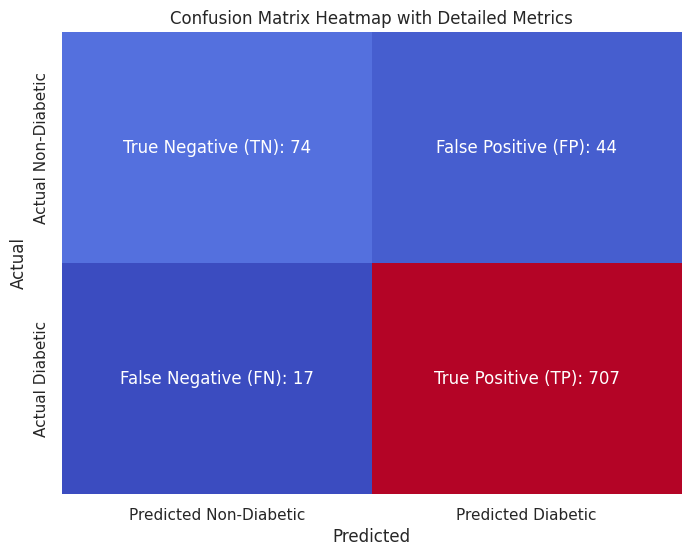

In [ ]:
#@title ### Punnett square or 'confusion matrix' of our logistic regression model
#@markdown Try to remember the different classification metrics and how to calculate them from the different values of our punnett square.
#@markdown
#@markdown **Think of what tiles below are most important given this is for diabetes prediction...**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Prepare data
selected_features = ['LDL-Cholesterol, Friedewald (mg/dL)', 'Glycohemoglobin (%)']
X = reduced_df[selected_features].values
y = reduced_df['Diabetes'].values

# Split data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap visualization with detailed metrics
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='coolwarm', cbar=False, ax=ax,
            xticklabels=["Predicted Non-Diabetic", "Predicted Diabetic"],
            yticklabels=["Actual Non-Diabetic", "Actual Diabetic"])

# Add detailed annotations for True Positives, True Negatives, False Positives, and False Negatives
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == 0 and j == 0:
            text = f"True Negative (TN): {cm[i, j]}"
        elif i == 1 and j == 1:
            text = f"True Positive (TP): {cm[i, j]}"
        elif i == 0 and j == 1:
            text = f"False Positive (FP): {cm[i, j]}"
        elif i == 1 and j == 0:
            text = f"False Negative (FN): {cm[i, j]}"
        ax.text(j + 0.5, i + 0.5, text,
                ha="center", va="center", color="white")

ax.set_title('Confusion Matrix Heatmap with Detailed Metrics')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

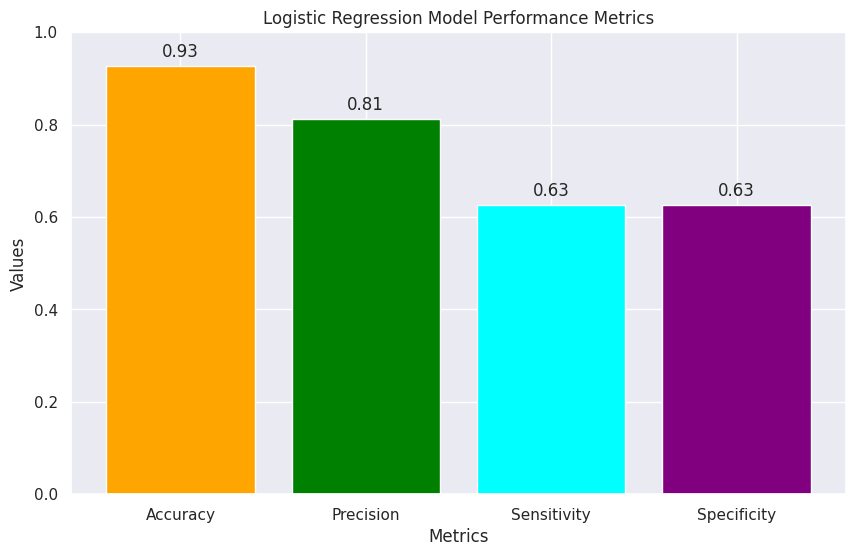

In [ ]:
#@title ### Let's now look at our logistic regression model's performance across known metrics
#@markdown Given what we discussed earlier, is this a good model of the data? Are there any possible sources of misinterpretation?
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Prepare data
selected_features = ['LDL-Cholesterol, Friedewald (mg/dL)', 'Glycohemoglobin (%)']
X = reduced_df[selected_features].values
y = reduced_df['Diabetes'].values

# Split data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity is the same as recall
specificity = tn / (tn + fp)

# Bar chart data
metrics = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity']
values = [accuracy, precision, sensitivity, specificity]

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['orange', 'green', 'cyan', 'purple'])

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Set chart title and labels
plt.ylim(0, 1)
plt.title('Logistic Regression Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()

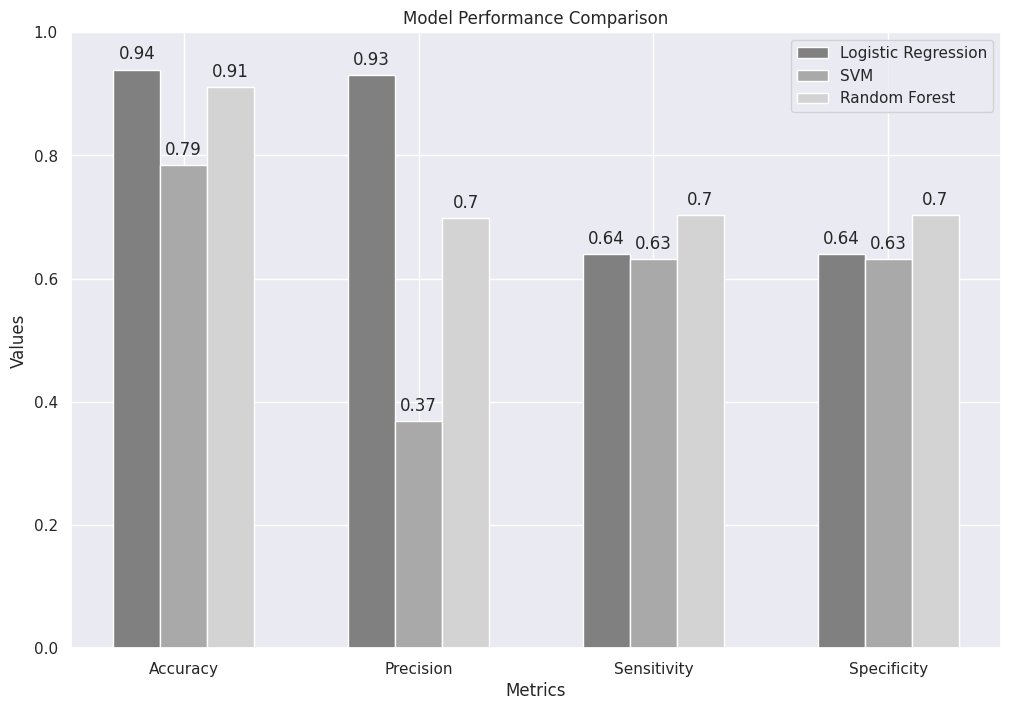

In [ ]:
#@title ### Finally, for classification, let's put this together by training multiple ML models and comparing their performance
#@markdown Try to recall the strengths and weaknesses of eah model.
#@markdown If you don't remember, that's fine! Just make sure it is part of your final interpretation of the results each time.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split

# Prepare data
selected_features = ['LDL-Cholesterol, Friedewald (mg/dL)', 'Glycohemoglobin (%)']
X = reduced_df[selected_features].values
y = reduced_df['Diabetes'].values

# Split data into training and test sets using stratified split (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Train SVM model with class weights
svm_model = SVC(probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Compute metrics for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
sensitivity_lr = recall_score(y_test, y_pred_lr)
specificity_lr = tn_lr / (tn_lr + fp_lr)

# Compute metrics for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
sensitivity_svm = recall_score(y_test, y_pred_svm)
specificity_svm = tn_svm / (tn_svm + fp_svm)

# Compute metrics for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
sensitivity_rf = recall_score(y_test, y_pred_rf)
specificity_rf = tn_rf / (tn_rf + fp_rf)

# Bar chart data
metrics = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity']
values_lr = [accuracy_lr, precision_lr, sensitivity_lr, specificity_lr]
values_svm = [accuracy_svm, precision_svm, sensitivity_svm, specificity_svm]
values_rf = [accuracy_rf, precision_rf, sensitivity_rf, specificity_rf]

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(metrics))

bars_lr = plt.bar(index, values_lr, bar_width, label='Logistic Regression', color='grey')
bars_svm = plt.bar(index + bar_width, values_svm, bar_width, label='SVM', color='darkgrey')
bars_rf = plt.bar(index + 2 * bar_width, values_rf, bar_width, label='Random Forest', color='lightgrey')

# Add text annotations
for bars in [bars_lr, bars_svm, bars_rf]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Set chart title and labels
plt.ylim(0, 1)
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(index + bar_width, metrics)
plt.legend()

plt.show()

Why do you think the SVM is performing so poorly? Perhaps try looking at the Punnett Squares/Confusion Matrices...



In [ ]:
#@title ### Punnett square or 'confusion matrix' for each model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from ipywidgets import interact, widgets

# Prepare data
selected_features = ['LDL-Cholesterol, Friedewald (mg/dL)', 'Glycohemoglobin (%)']
X = reduced_df[selected_features].values
y = reduced_df['Diabetes'].values

# Split data into training and test sets using stratified split (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Train models
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

svm_model = SVC(probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Function to plot confusion matrix
def plot_confusion_matrix(model):
    if model == 'Logistic Regression':
        cm = cm_lr
        title = 'Logistic Regression Confusion Matrix'
    elif model == 'SVM':
        cm = cm_svm
        title = 'SVM Confusion Matrix'
    elif model == 'Random Forest':
        cm = cm_rf
        title = 'Random Forest Confusion Matrix'

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='coolwarm', cbar=False, ax=ax,
                xticklabels=["Predicted Non-Diabetic", "Predicted Diabetic"],
                yticklabels=["Actual Non-Diabetic", "Actual Diabetic"])

    # Add detailed annotations for True Positives, True Negatives, False Positives, and False Negatives
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == 0 and j == 0:
                text = f"True Negative (TN): {cm[i, j]}"
            elif i == 1 and j == 1:
                text = f"True Positive (TP): {cm[i, j]}"
            elif i == 0 and j == 1:
                text = f"False Positive (FP): {cm[i, j]}"
            elif i == 1 and j == 0:
                text = f"False Negative (FN): {cm[i, j]}"
            ax.text(j + 0.5, i + 0.5, text,
                    ha="center", va="center", color="white")

    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

# Create widget
interact(
    plot_confusion_matrix,
    model=widgets.Dropdown(
        options=['Logistic Regression', 'SVM', 'Random Forest'],
        value='Logistic Regression',
        description='Model:',
        disabled=False
    )
);

interactive(children=(Dropdown(description='Model:', options=('Logistic Regression', 'SVM', 'Random Forest'), …